# At this stage we explain the design of an ACO algorithm, provide a greedy baseline solution, and then present an ACO-based implementation



## Objective Function and Constraints
### Objective Function:
Minimize the overall cost given by the sum of two components:

$$Score = gift\_cost + P$$

Accounting Penalty Component 𝑃:

$$P = \sum_{d=100}^{1} \frac{(N_d - 125)}{400} N_d^{\left(\frac{1}{2} + \frac{|N_d - N_{d+1}|}{50} \right)}$$

where:

$𝑁_𝑑$ is the number of people assigned to day 𝑑

$𝑁_{𝑑+1}$​ is the number of people assigned to the next day

For day 100, assume $𝑁_{101}$ = $𝑁_{100}$

#### Total Family Penalty $gift\_cost = \sum f_n$:

Each family 𝑛 is assigned a cost based on which priority day they receive. The function
$𝑓_𝑛$ is defined as follows (with 𝑁 as the number of people in the family):

If the 0th day is chosen:
$𝑓_𝑛 = 0$

1st priority:
$𝑓_𝑛 = 50$

2nd priority:
$𝑓_𝑛 = 50 + 9N$

3rd priority:
$𝑓_𝑛 = 100 + 9N$

4th priority:
$𝑓_𝑛 = 200 + 9N$

5th priority:
$𝑓_𝑛 = 200 + 18N$

6th priority:
$𝑓_𝑛 = 300 + 18N$

7th priority:
$𝑓_𝑛 = 300 + 36N$

8th priority:
$𝑓_𝑛 = 400 + 36N$

9th priority:
$𝑓_𝑛 = 500 + 235N$

10th priority:
$𝑓_𝑛 = 500 + 434N$

### Constraints:

1. Daily Capacity Constraint:
For each day
𝑑, the total number of people
$𝑁_𝑑$ must be between 125 and 300:
$$125 \leq N_d \leq 300, \quad \forall d \in \{1, 2, \dots, 100\}$$

2. Family Assignment Constraint:
Each family is assigned to exactly one day.

3. Smoothness Constraint:
To avoid large jumps in daily attendance (which causes a huge penalty in the objective function), the difference between
$𝑁_𝑑$ and $𝑁_{𝑑+1}$ should be minimized.


## Importing libraries, dataset preparation

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import plotly.express as px
import time
import random

In [2]:
data_filename = 'dataset/family_data.csv'
with open(data_filename) as f:
    reader = csv.DictReader(f)
    family_dict = list(reader)

In [3]:
family_dataset = []
for family in family_dict:
  family_data = dict()
  family_data['id'] = int(family['family_id'])
  family_data['n_members'] = int(family['n_people'])
  choise_list = []
  for i in range(10):
    choise_list.append(int(family['choice_' + str(i)]))
  family_data['dates'] = choise_list
  family_dataset.append(family_data)

After analyzing the dataset, we noticed that the key value in the final sum for Santa is the penalty:

$$P = \sum_{d=100}^{1} \frac{(N_d - 125)}{400} N_d^{\left(\frac{1}{2} + \frac{|N_d - N_{d+1}|}{50} \right)}$$

Optimal strategy is to minimize the difference between consecutive days → smoothing the distribution of people across days.

So, let us create greedy algorithm implementing this strategy

# Greedy algorithm

c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


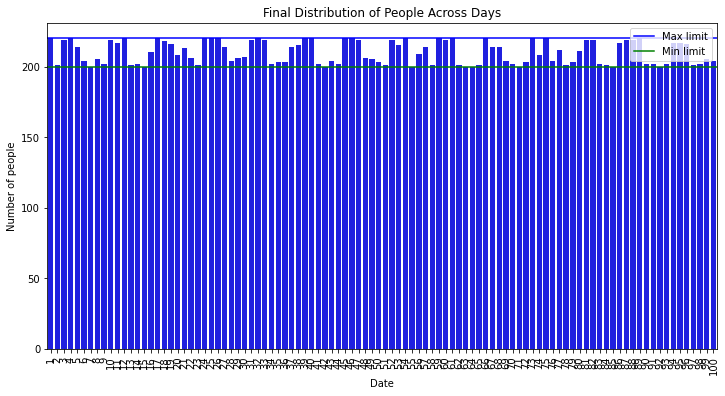

Total Gift Cost: 170350.00
Total Accounting Penalty: 827.84
Score: 171177.84
Time the greedy method is working:  4.149150609970093


In [ ]:
DAYS = 100
MIN_PEOPLE_PER_DAY = 200
MAX_PEOPLE_PER_DAY = 220
PRIORITIES = 10

def compute_family_penalty(n_members, priority):
    penalties = [0, 50, 50 + 9 * n_members, 100 + 9 * n_members, 200 + 9 * n_members,
                 200 + 18 * n_members, 300 + 18 * n_members, 300 + 36 * n_members,
                 400 + 36 * n_members, 500 + 235 * n_members, 500 + 434 * n_members]
    return penalties[priority]

def find_cheapest_family_to_move_out(overcrowded_day, day_capacity, assignments):
    min_cost_per_person = float('inf')
    best_family = None

    for family in family_dataset:
        if assignments[family['id']][0] != overcrowded_day:
            continue  # Family not assigned to this day; skip

        current_day, current_priority = assignments[family['id']]
        current_cost = compute_family_penalty(family['n_members'], current_priority)

        # Try next preferences until finding a feasible day
        for next_priority in range(current_priority + 1, PRIORITIES): 
            next_day = family['dates'][next_priority]
            if day_capacity[next_day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                next_cost = compute_family_penalty(family['n_members'], next_priority)
                cost_delta = (next_cost - current_cost) / family['n_members']
                if cost_delta < min_cost_per_person:
                    min_cost_per_person = cost_delta
                    best_family = (family, next_day, next_priority)
                break  # Only consider the next feasible preference

    return best_family  # Returns (family, new_day, new_priority) or None

def move_family(best_family, day_capacity, assignments):
    if not best_family:
        return  # No family to move (edge case)
    
    family, new_day, new_priority = best_family
    old_day, old_priority = assignments[family['id']]
    
    # Update day counts
    day_capacity[old_day] -= family['n_members']
    day_capacity[new_day] += family['n_members']
    
    # Update the family's assignment
    assignments[family['id']] = (new_day, new_priority)

def find_cheapest_family_to_move_in(undercrowded_day, day_capacity, assignments):
    best_family = None
    min_cost_per_person = float('inf')

    for family in family_dataset:
        # print(family['id'])
        current_day, current_priority = assignments[family['id']]
        current_cost = compute_family_penalty(family['n_members'], current_priority)
        # if current day accepts enough participants
        if day_capacity[current_day] - family['n_members'] < MIN_PEOPLE_PER_DAY:
            continue

        for next_priority in range(current_priority + 1, PRIORITIES): 
            next_day = family['dates'][next_priority]
            if next_day == undercrowded_day:
                next_cost = compute_family_penalty(family['n_members'], next_priority)
                cost_delta = (next_cost - current_cost) / family['n_members']
                if cost_delta < min_cost_per_person:
                    min_cost_per_person = cost_delta
                    best_family = (family, next_day, next_priority)
                break  # Only consider the next feasible preference

    return best_family  # Returns (family, new_day, new_priority) or None

start_time = time.time()

day_capacity = defaultdict(int)  # Stores the number of people assigned to each day
assignments = {}  # family_id -> (day, priority)
gift_cost = 0

# Phase 1: Assign all to 1st choice
for family in family_dataset:
    day = family['dates'][0]
    day_capacity[day] += family['n_members']
    assignments[family['id']] = (day, 0)

# Phase 2: Fix overcapacity
for day in range(1, DAYS+1):
    while day_capacity[day] > MAX_PEOPLE_PER_DAY:
        # Find family with smallest cost increase per person
        best_family = find_cheapest_family_to_move_out(day, day_capacity, assignments)
        move_family(best_family, day_capacity, assignments)
        if not best_family:
            print(f"Could not reduce number of visitors on day {day}")
            break

# Phase 3: Fix undercapacity
for day in range(1, DAYS+1):
    while day_capacity[day] < MIN_PEOPLE_PER_DAY:
        # Find family that benefits most from moving here
        best_family = find_cheapest_family_to_move_in(day, day_capacity, assignments)
        move_family(best_family, day_capacity, assignments)
        if not best_family:
            print(f"Could not increase number of visitors on day {day}")
            break

# Phase 4: Compute penalties
gift_cost = 0
penalty = 0

for family in family_dataset:
    gift_cost += compute_family_penalty(family['n_members'], assignments[family['id']][1])

days_sorted = sorted(day_capacity.keys())
for i, day in enumerate(days_sorted):
    Nd = day_capacity[day]
    Nd_next = day_capacity[days_sorted[i+1]] if i < len(days_sorted) - 1 else Nd  # Handle last day case

    term = ((Nd - 125) / 400) * (Nd ** (1/2 + abs(Nd - Nd_next) / 50))
    penalty += term

end_time = time.time()

# Plot the distribution of people across days
df_capacity = pd.DataFrame(list(day_capacity.items()), columns=['Date', 'Number of people'])
df_capacity = df_capacity.sort_values('Date')

plt.figure(figsize=(12, 6))
sns.barplot(x=df_capacity['Date'], y=df_capacity['Number of people'], color='b')

plt.axhline(y=MAX_PEOPLE_PER_DAY, color='b', linestyle='-', label="Max limit")
plt.axhline(y=MIN_PEOPLE_PER_DAY, color='g', linestyle='-', label="Min limit")
plt.xlabel("Day")
plt.ylabel("Number of people")
plt.title("Final Distribution of People Across Days (Greedy algorithm)")
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Print the final penalty values
print(f"Total Cost: {gift_cost:.2f}")
print(f"Total Accounting Penalty: {penalty:.2f}")
print(f"Score: {gift_cost + penalty:.2f}")
print("Time the greedy method is working: ", end_time - start_time)


# Research and Design the ACO Algorithm
## Ant Colony Optimization (ACO) for Scheduling Families:

### Graph Representation:

Each node in the graph represents a potential assignment of a family to a day (or, more generally, a decision point for each family).
The ants construct a complete solution by selecting a set of nodes - choosing one day for each family.
The decision is guided by assigning pheromone to the nodes and heuristic information.


### Heuristic Information:

The desirability of assigning a family to a given day can be based on 
1) Penalty associated with that family’s priority (the lower the cost
$𝑓_𝑛​$, the better)
2) Accounting penalty: how close that day’s current load is to the lower bound (125) while keeping the smooth transition between days (i.e., minimizing
$|𝑁_𝑑 − 𝑁_{𝑑+1}|$)

For our first try we will use the following heuristics:
$$\eta_{i, j} = 1 / f_n$$

where $f_n$ is the gift cost for assigning family $i$ to day $j$

### Pheromone:

Pheromone levels are maintained on the nodes that connect a family with a day.
After each ant constructs a solution (i.e., a full assignment of families to days), the objective function
$Score$ is computed.
Lower-cost solutions deposit more pheromone along the corresponding assignments, thereby reinforcing these choices.

### Ant Decision Rule:

At each decision point (for each family), an ant probabilistically chooses a day using the rule:

$$p_{i,j} = \frac{\tau_{i,j}^\alpha \cdot \eta_{i,j}^\beta}{\sum_{k \in \text{allowed}} \tau_{i,k}^\alpha \cdot \eta_{i,k}^\beta}$$

where:

$\tau_{i,j}$ is the pheromone value for assigning family $𝑖$ to day $𝑗$

$\eta_{i,j}$ is the heuristic value (e.g., based on current day load and penalty function $𝑓_𝑛$)

$\alpha$ and $\beta$ are parameters that control the influence of pheromone and heuristic information, respectively

### Pheromone Update:

After all ants have built their solutions, update pheromones by evaporating a fraction of the old pheromone and then adding new pheromone proportional to the quality of each solution.
This helps balance exploration and exploitation.


### Algorithm Iteration:

Repeat the solution construction and pheromone update for a fixed number of iterations or until convergence.


## The first version of the ACO algorithm

First, let's create and implement the ACO algorithm. As you can see from the results, it works very slowly on such a large dataset. In a minute of work, the program was unable to lower the cost significantly.

Iteration 1, Best Cost so far: 1918586636.33323
Iteration 2, Best Cost so far: 1778911984.9485626
Iteration 3, Best Cost so far: 1778911984.9485626
Iteration 4, Best Cost so far: 1778911984.9485626
Iteration 5, Best Cost so far: 1778911984.9485626
Iteration 6, Best Cost so far: 1778911984.9485626
Iteration 7, Best Cost so far: 1778911984.9485626
Iteration 8, Best Cost so far: 1778911984.9485626
Iteration 9, Best Cost so far: 1778911984.9485626
Iteration 10, Best Cost so far: 1778911984.9485626
Iteration 11, Best Cost so far: 1778911984.9485626
Iteration 12, Best Cost so far: 1778911984.9485626
Iteration 13, Best Cost so far: 1778911984.9485626
Iteration 14, Best Cost so far: 1778911984.9485626
Iteration 15, Best Cost so far: 1778911984.9485626
Iteration 16, Best Cost so far: 1778911984.9485626
Iteration 17, Best Cost so far: 1778911984.9485626
Iteration 18, Best Cost so far: 1778911984.9485626
Iteration 19, Best Cost so far: 1778911984.9485626
Iteration 20, Best Cost so far: 1778911984

c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


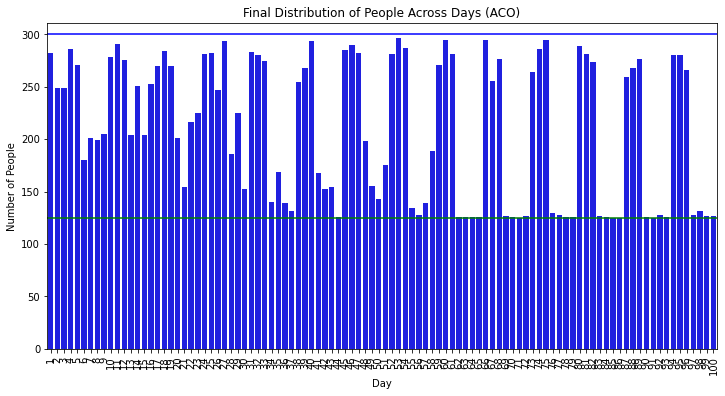

Score: 1778911984.9485626
Time the ACO algorithm is working:  611.3966963291168


In [ ]:
from functools import lru_cache

start_time = time.time()

# Number of families and days
DAYS = 100
PRIORITIES = 10
MIN_PEOPLE_PER_DAY = 125
MAX_PEOPLE_PER_DAY = 300
num_families = len(family_dataset)

# Parameters for ACO
num_ants = 10
num_iterations = 20
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic
rho = 0.1    # Evaporation rate

# Initialize pheromone trails: a dictionary mapping (family_id, priority_index) to pheromone level
# For each family, there are 10 possible choices (one for each priority)
pheromones = { (family['id'], i): 1.0 for family in family_dataset for i in range(PRIORITIES + 1) }

def move_family(best_family, day_capacity, assignments):
    if not best_family:
        return  # No family to move (edge case)
    
    family, new_day, new_priority = best_family
    old_day, old_priority = assignments[family['id']]
    
    # Update day counts
    day_capacity[old_day] -= family['n_members']
    day_capacity[new_day] += family['n_members']
    
    # Update the family's assignment
    assignments[family['id']] = (new_day, new_priority)

def find_cheapest_family_to_move_in(undercrowded_day, day_capacity, assignments):
    best_family = None
    min_cost_per_person = float('inf')

    for family in family_dataset:
        # print(family['id'])
        current_day, current_priority = assignments[family['id']]
        current_cost = compute_family_penalty(family['n_members'], current_priority)
        # if current day accepts enough participants
        if day_capacity[current_day] - family['n_members'] < MIN_PEOPLE_PER_DAY:
            continue

        for next_priority in range(current_priority + 1, PRIORITIES): 
            next_day = family['dates'][next_priority]
            if next_day == undercrowded_day:
                next_cost = compute_family_penalty(family['n_members'], next_priority)
                cost_delta = (next_cost - current_cost) / family['n_members']
                if cost_delta < min_cost_per_person:
                    min_cost_per_person = cost_delta
                    best_family = (family, next_day, next_priority)
                break  # Only consider the next feasible preference

    return best_family  # Returns (family, new_day, new_priority) or None

# Heuristic information: lower cost is more desirable.
# Here, we use the inverse of the family penalty for a given priority.
@lru_cache(maxsize=None)
def compute_family_penalty(n_members, priority):
    penalties = [0, 50, 50 + 9 * n_members, 100 + 9 * n_members, 200 + 9 * n_members,
                 200 + 18 * n_members, 300 + 18 * n_members, 300 + 36 * n_members,
                 400 + 36 * n_members, 500 + 235 * n_members, 500 + 434 * n_members]
    return penalties[priority]

# The heuristic desirability is the inverse of the penalty (adding a small constant to avoid division by zero)
def heuristic(n_members, priority):
    return 1.0 / (compute_family_penalty(n_members, priority) + 1e-6)

heuristics_cache = {}
for family in family_dataset:
    for priority in range(PRIORITIES):
        heuristics_cache[(family['id'], priority)] = heuristic(family['n_members'], priority)

# Evaluate a complete solution: assign each family to a day according to chosen priority
def compute_penalty(day_capacity):
    Nd = day_capacity[1:]  # skip index 0
    Nd_next = np.roll(Nd, -1)
    Nd_next[-1] = Nd[-1]
    term = ((Nd - 125) / 400) * (Nd ** (1/2 + abs(Nd - Nd_next) / 50))
    return term.sum()

def evaluate_solution(solution):
    day_capacity = np.zeros(DAYS+1, dtype=int)
    gift_cost = 0

    for family in family_dataset:
        if family['id'] in solution:
            day, priority = solution[family['id']]
            gift_cost += compute_family_penalty(family['n_members'], priority)
            day_capacity[day] += family['n_members']

    penalty = compute_penalty(day_capacity)
    return penalty + gift_cost, day_capacity

# Construct solution for one ant
def construct_solution():
    solution = {}  # mapping family id -> (assigned day, chosen priority)
    # Create a copy of daily capacity for assignment
    day_capacity = np.zeros(DAYS+1, dtype=int)
    day_capacity[0] = MAX_PEOPLE_PER_DAY

    # Shuffle families to add stochasticity
    families = family_dataset.copy()
    random.shuffle(families)

    for family in families:
        probs = np.zeros(PRIORITIES)
        choices = []
        # For each of the 10 priorities, check if assignment is possible
        for priority in range(PRIORITIES):
            # Get the day corresponding to this priority
            day = family['dates'][priority]
            if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                tau = pheromones[(family['id'], priority)]
                eta = heuristics_cache[(family['n_members'], priority)]
                probs[priority] = (tau ** alpha) * (eta ** beta)
                choices.append((day, priority))
            else:
                probs[priority] = 0
                choices.append((None, priority))

        # Normalize probabilities if sum > 0
        if probs.sum() > 0:
            probs /= probs.sum()
            # Roulette wheel selection for priority
            selected_index = np.random.choice(range(PRIORITIES), p=probs)
            selected_day, selected_priority = choices[selected_index]
        else:
            min_capacity = day_capacity.min()
            tolerance = 5  # Absolute tolerance (e.g., within 5 people of minimum)
            candidate_days = np.where(day_capacity <= min_capacity + tolerance)[0]
            selected_day = np.random.choice(candidate_days) 
            
        # Update solution and current load
        solution[family['id']] = (selected_day, selected_priority)
        day_capacity[selected_day] += family['n_members']

    
    # Fix undercapacity
    for day in range(1, DAYS+1):
        while day_capacity[day] < MIN_PEOPLE_PER_DAY:
            # Find family that benefits most from moving here
            best_family = find_cheapest_family_to_move_in(day, day_capacity, solution)
            move_family(best_family, day_capacity, solution)
            if not best_family:
                print(f"Could not increase number of visitors on day {day}")
                break

    return solution

# ACO main loop
best_solution = None
best_cost = float('inf')

for iteration in range(num_iterations):
    all_solutions = []
    for ant in range(num_ants):
        sol = construct_solution()
        cost, capacity = evaluate_solution(sol)
        all_solutions.append((sol, cost))
        if cost < best_cost:
            best_cost = cost
            best_solution = sol

    # Update pheromones: evaporation and reinforcement
    for key in pheromones:
        pheromones[key] *= (1 - rho)

    # Deposit pheromones from best solutions found in this iteration
    for sol, cost in all_solutions:
        # Use inverse cost as deposit amount
        deposit = 1.0 / (cost + 1e-6)
        for family_id, (_, priority) in sol.items():
            pheromones[(family_id, priority)] += deposit

    print(f"Iteration {iteration+1}, Best Cost so far: {best_cost}")

end_time = time.time()

# Print best solution and corresponding daily load distribution
final_cost, final_capacity = evaluate_solution(best_solution)

# Plot the final daily distribution
days = np.arange(1, DAYS+1)
people_counts = final_capacity[1:]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.axhline(y=MAX_PEOPLE_PER_DAY, color='b', linestyle='-', label="Max limit")
plt.axhline(y=MIN_PEOPLE_PER_DAY, color='g', linestyle='-', label="Min limit")
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (ACO)")
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Print best solution and corresponding daily load distribution
print("Score:", final_cost)
print("Time the ACO algorithm is working: ", end_time - start_time)

We notice that increasing the number of ants or cycles does not improve the result. Perhaps the program works poorly because the initial solution is built inefficiently. Then we will try to combine the ACO with a greedy algorithm, which gives a good starting point.

## Combining the greedy algorithm with the first version of the ACO

Greedy solution score: 171177.84121737807


c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


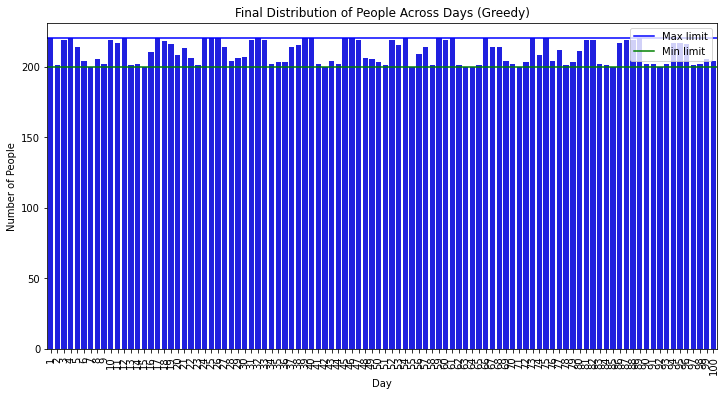

ACO: Iteration 1, Best Cost so far: 171177.84121737807
ACO: Iteration 2, Best Cost so far: 171177.84121737807
ACO: Iteration 3, Best Cost so far: 171177.84121737807
ACO: Iteration 4, Best Cost so far: 171177.84121737807
ACO: Iteration 5, Best Cost so far: 171177.84121737807
ACO: Iteration 6, Best Cost so far: 171177.84121737807
ACO: Iteration 7, Best Cost so far: 171177.84121737807
ACO: Iteration 8, Best Cost so far: 171177.84121737807
ACO: Iteration 9, Best Cost so far: 171177.84121737807
ACO: Iteration 10, Best Cost so far: 171177.84121737807
ACO: Iteration 11, Best Cost so far: 171177.84121737807
ACO: Iteration 12, Best Cost so far: 171177.84121737807
ACO: Iteration 13, Best Cost so far: 171177.84121737807
ACO: Iteration 14, Best Cost so far: 171177.84121737807
ACO: Iteration 15, Best Cost so far: 171177.84121737807
ACO: Iteration 16, Best Cost so far: 171177.84121737807
ACO: Iteration 17, Best Cost so far: 171177.84121737807
ACO: Iteration 18, Best Cost so far: 171177.84121737807
A

c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


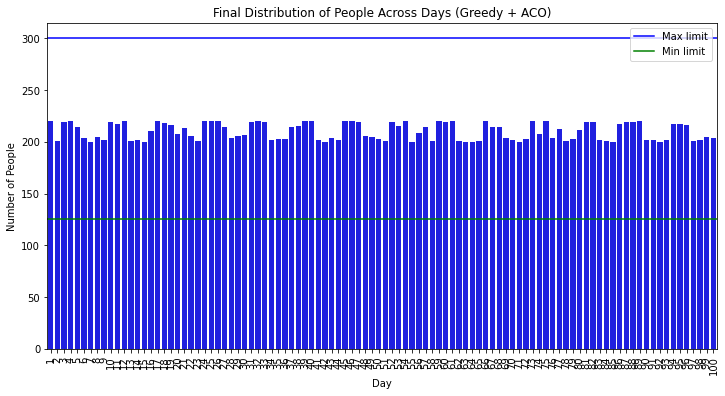

Greedy + ACO Score: 171177.84
Time the greedy method is working:  367.05343651771545


In [23]:
from functools import lru_cache

DAYS = 100
MIN_PEOPLE_PER_DAY_GREEDY = 200
MAX_PEOPLE_PER_DAY_GREEDY = 220
PRIORITIES = 10
MIN_PEOPLE_PER_DAY = 125
MAX_PEOPLE_PER_DAY = 300
num_families = len(family_dataset)

# Parameters for ACO
num_ants = 10
num_iterations = 20
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic
rho = 0.1    # Evaporation rate

# Initialize pheromone trails: a dictionary mapping (family_id, priority_index) to pheromone level
# For each family, there are 10 possible choices (one for each priority)
pheromones = { (family['id'], i): 1.0 for family in family_dataset for i in range(PRIORITIES + 1) }

@lru_cache
def compute_family_penalty(n_members, priority):
    penalties = [0, 50, 50 + 9 * n_members, 100 + 9 * n_members, 200 + 9 * n_members,
                 200 + 18 * n_members, 300 + 18 * n_members, 300 + 36 * n_members,
                 400 + 36 * n_members, 500 + 235 * n_members, 500 + 434 * n_members]
    return penalties[priority]

def find_cheapest_family_to_move_out(overcrowded_day, day_capacity, assignments, upperbound):
    min_cost_per_person = float('inf')
    best_family = None

    for family in family_dataset:
        if assignments[family['id']][0] != overcrowded_day:
            continue  # Family not assigned to this day; skip

        current_day, current_priority = assignments[family['id']]
        current_cost = compute_family_penalty(family['n_members'], current_priority)

        # Try next preferences until finding a feasible day
        for next_priority in range(current_priority + 1, PRIORITIES): 
            next_day = family['dates'][next_priority]
            if day_capacity[next_day] + family['n_members'] <= upperbound:
                next_cost = compute_family_penalty(family['n_members'], next_priority)
                cost_delta = (next_cost - current_cost) / family['n_members']
                if cost_delta < min_cost_per_person:
                    min_cost_per_person = cost_delta
                    best_family = (family, next_day, next_priority)
                break  # Only consider the next feasible preference

    return best_family  # Returns (family, new_day, new_priority) or None

def move_family(best_family, day_capacity, assignments):
    if not best_family:
        return  # No family to move (edge case)
    
    family, new_day, new_priority = best_family
    old_day, old_priority = assignments[family['id']]
    
    # Update day counts
    day_capacity[old_day] -= family['n_members']
    day_capacity[new_day] += family['n_members']
    
    # Update the family's assignment
    assignments[family['id']] = (new_day, new_priority)

def find_cheapest_family_to_move_in(undercrowded_day, day_capacity, assignments, lowerbound):
    best_family = None
    min_cost_per_person = float('inf')

    for family in family_dataset:
        # print(family['id'])
        current_day, current_priority = assignments[family['id']]
        current_cost = compute_family_penalty(family['n_members'], current_priority)
        # if current day accepts enough participants
        if day_capacity[current_day] - family['n_members'] < lowerbound:
            continue

        for next_priority in range(current_priority + 1, PRIORITIES): 
            next_day = family['dates'][next_priority]
            if next_day == undercrowded_day:
                next_cost = compute_family_penalty(family['n_members'], next_priority)
                cost_delta = (next_cost - current_cost) / family['n_members']
                if cost_delta < min_cost_per_person:
                    min_cost_per_person = cost_delta
                    best_family = (family, next_day, next_priority)
                break  # Only consider the next feasible preference

    return best_family  # Returns (family, new_day, new_priority) or None

def greedy_solution():
    day_capacity = np.zeros(DAYS+1, dtype=int)  # Stores the number of people assigned to each day
    assignments = {}  # family_id -> (day, priority)

    # Phase 1: Assign all to 1st choice
    for family in family_dataset:
        day = family['dates'][0]
        day_capacity[day] += family['n_members']
        assignments[family['id']] = (day, 0)

    # Phase 2: Fix overcapacity
    for day in range(1, DAYS+1):
        while day_capacity[day] > MAX_PEOPLE_PER_DAY_GREEDY:
            # Find family with smallest cost increase per person
            best_family = find_cheapest_family_to_move_out(day, day_capacity, assignments, MAX_PEOPLE_PER_DAY_GREEDY)
            move_family(best_family, day_capacity, assignments)
            if not best_family:
                print(f"Could not reduce number of visitors on day {day}")
                break

    # Phase 3: Fix undercapacity
    for day in range(1, DAYS+1):
        while day_capacity[day] < MIN_PEOPLE_PER_DAY_GREEDY:
            # Find family that benefits most from moving here
            best_family = find_cheapest_family_to_move_in(day, day_capacity, assignments, MIN_PEOPLE_PER_DAY_GREEDY)
            move_family(best_family, day_capacity, assignments)
            if not best_family:
                print(f"Could not increase number of visitors on day {day}")
                break
    
    return assignments

# The heuristic desirability is the inverse of the penalty (adding a small constant to avoid division by zero)
def heuristic(n_members, priority):
    return 1.0 / (compute_family_penalty(n_members, priority) + 1e-6)

heuristics_cache = {}
for family in family_dataset:
    for priority in range(PRIORITIES):
        heuristics_cache[(family['id'], priority)] = heuristic(family['n_members'], priority)

# Evaluate a complete solution: assign each family to a day according to chosen priority
def compute_penalty(day_capacity):
    Nd = day_capacity[1:]  # skip index 0
    Nd_next = np.roll(Nd, -1)
    Nd_next[-1] = Nd[-1]
    term = ((Nd - 125) / 400) * (Nd ** (1/2 + abs(Nd - Nd_next) / 50))
    return term.sum()

def evaluate_solution(solution):
    day_capacity = np.zeros(DAYS+1, dtype=int)
    gift_cost = 0

    for family in family_dataset:
        if family['id'] in solution:
            day, priority = solution[family['id']]
            gift_cost += compute_family_penalty(family['n_members'], priority)
            day_capacity[day] += family['n_members']

    penalty = compute_penalty(day_capacity)
    return penalty + gift_cost, day_capacity

# Construct solution for one ant
def construct_solution():
    solution = {}  # mapping family id -> (assigned day, chosen priority)
    # Create a copy of daily capacity for assignment
    day_capacity = np.zeros(DAYS+1, dtype=int)
    day_capacity[0] = MAX_PEOPLE_PER_DAY

    # Shuffle families to add stochasticity
    families = family_dataset.copy()
    random.shuffle(families)

    for family in families:
        probs = np.zeros(PRIORITIES)
        choices = []
        # For each of the 10 priorities, check if assignment is possible
        for priority in range(PRIORITIES):
            # Get the day corresponding to this priority
            day = family['dates'][priority]
            if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                tau = pheromones[(family['id'], priority)]
                eta = heuristics_cache[(family['n_members'], priority)]
                probs[priority] = (tau ** alpha) * (eta ** beta)
                choices.append((day, priority))
            else:
                probs[priority] = 0
                choices.append((None, priority))

        # Normalize probabilities if sum > 0
        if probs.sum() > 0:
            probs /= probs.sum()
            # Roulette wheel selection for priority
            selected_index = np.random.choice(range(PRIORITIES), p=probs)
            selected_day, selected_priority = choices[selected_index]
        else:
            min_capacity = day_capacity.min()
            tolerance = 5  # Absolute tolerance (e.g., within 5 people of minimum)
            candidate_days = np.where(day_capacity <= min_capacity + tolerance)[0]
            selected_day = np.random.choice(candidate_days) 
            
        # Update solution and current load
        solution[family['id']] = (selected_day, selected_priority)
        day_capacity[selected_day] += family['n_members']

    
    # Fix undercapacity
    for day in range(1, DAYS+1):
        while day_capacity[day] < MIN_PEOPLE_PER_DAY:
            # Find family that benefits most from moving here
            best_family = find_cheapest_family_to_move_in(day, day_capacity, solution, MIN_PEOPLE_PER_DAY)
            move_family(best_family, day_capacity, solution)
            if not best_family:
                print(f"Could not increase number of visitors on day {day}")
                break

    return solution


# ACO
def ACO_solution(initial_solution, initial_cost):
    best_solution = initial_solution
    best_cost = initial_cost

    deposit = 1.0 / (initial_cost + 1e-6)
    for family_id, (_, priority) in initial_solution.items():
        pheromones[(family_id, priority)] += deposit

    for iteration in range(num_iterations):
        all_solutions = []
        for ant in range(num_ants):
            sol = construct_solution()
            cost, capacity = evaluate_solution(sol)
            all_solutions.append((sol, cost))
            if cost < best_cost:
                best_cost = cost
                best_solution = sol

        # Update pheromones: evaporation and reinforcement
        for key in pheromones:
            pheromones[key] *= (1 - rho)

        # Deposit pheromones from best solutions found in this iteration
        for sol, cost in all_solutions:
            # Use inverse cost as deposit amount
            deposit = 1.0 / (cost + 1e-6)
            for family_id, (_, priority) in sol.items():
                pheromones[(family_id, priority)] += deposit

        print(f"ACO: Iteration {iteration+1}, Best Cost so far: {best_cost}")
    return best_solution

start_time = time.time()

greedy_sol = greedy_solution()
greedy_cost, greedy_capacity = evaluate_solution(greedy_sol)

print("Greedy solution score:", greedy_cost)
# Plot the final daily distribution
days = np.arange(1, DAYS+1)
people_counts = greedy_capacity[1:]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.axhline(y=MAX_PEOPLE_PER_DAY_GREEDY, color='b', linestyle='-', label="Max limit")
plt.axhline(y=MIN_PEOPLE_PER_DAY_GREEDY, color='g', linestyle='-', label="Min limit")
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (Greedy)")
plt.legend()
plt.xticks(rotation=90)
plt.show()

aco_sol = ACO_solution(greedy_sol, greedy_cost)
final_cost, final_capacity = evaluate_solution(aco_sol)

end_time = time.time()

# Plot the final daily distribution
days = np.arange(1, DAYS+1)
people_counts = final_capacity[1:]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.axhline(y=MAX_PEOPLE_PER_DAY, color='b', linestyle='-', label="Max limit")
plt.axhline(y=MIN_PEOPLE_PER_DAY, color='g', linestyle='-', label="Min limit")
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (Greedy + ACO)")
plt.legend()
plt.xticks(rotation=90)
plt.show()

print(f"Greedy + ACO Score: {final_cost:.2f}")
print("Time the greedy method is working: ", end_time - start_time)


While changing the start data made the ACO algorithm faster, it did not improve the algorithm result. This means that the ACO algorithm itself is implemented inefficiently. By analyzing the algorithm, we notice that in the construct_solution() function, that is, at the stage of calculating the Ant Decision Rule, we do not take into account the change in Accounting Penalty Component 𝑃. When assigning a family to a specific day, the difference between the number of visitors between adjacent days changes. Moreover, P changes not only for this day, but also for the previous one. Let's rewrite the ACO algorithm taking these changes into account.

### Changed heuristics:

$$\eta_{i, j} = 1 / (f_n + \Delta P)$$

where:

$f_n$ is the gift cost for assigning family $i$ to day $j$

$\Delta P$ is the accounting penalty increment after assigning family $i$ to day $j$

----

Since the daily capacity may temporarily violate the lower boundary during solution construction, we include absolute values in the Accounting Penalty formula:

$$P = \sum_{d=100}^{1} \frac{|N_d - 125|}{400} N_d^{\left(\frac{1}{2} + \frac{|N_d - N_{d+1}|}{50} \right)}$$


## The second version of the ACO algorithm

Iteration 1, Best Cost so far: 334354.0554573282
Iteration 2, Best Cost so far: 334354.0554573282
Iteration 3, Best Cost so far: 334354.0554573282
Iteration 4, Best Cost so far: 328640.8269302709
Iteration 5, Best Cost so far: 328640.8269302709
Iteration 6, Best Cost so far: 328640.8269302709
Iteration 7, Best Cost so far: 312384.41425970686
Iteration 8, Best Cost so far: 312384.41425970686
Iteration 9, Best Cost so far: 312384.41425970686
Iteration 10, Best Cost so far: 312384.41425970686
Iteration 11, Best Cost so far: 312384.41425970686
Iteration 12, Best Cost so far: 312384.41425970686
Iteration 13, Best Cost so far: 312384.41425970686
Iteration 14, Best Cost so far: 312384.41425970686
Iteration 15, Best Cost so far: 312384.41425970686
Iteration 16, Best Cost so far: 312384.41425970686
Iteration 17, Best Cost so far: 311073.29936176597
Iteration 18, Best Cost so far: 311073.29936176597
Iteration 19, Best Cost so far: 311073.29936176597
Iteration 20, Best Cost so far: 311073.2993617

c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


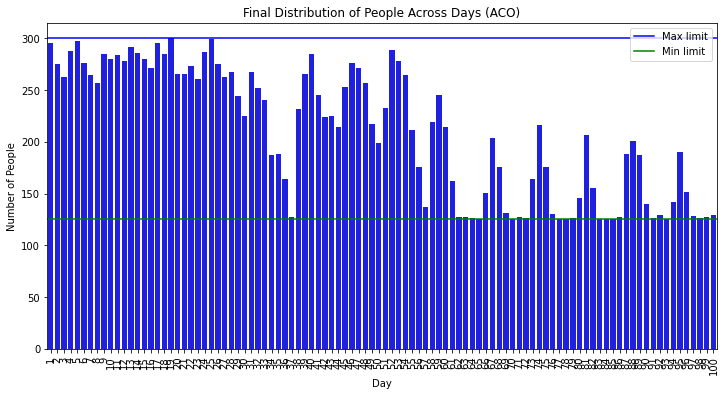

Score: 311073.29936176597
Time the ACO algorithm is working:  1043.708922624588


In [24]:
from functools import lru_cache

start_time = time.time()

# Number of families and days
DAYS = 100
PRIORITIES = 10
MIN_PEOPLE_PER_DAY = 125
MAX_PEOPLE_PER_DAY = 300
num_families = len(family_dataset)

# Parameters for ACO
num_ants = 10
num_iterations = 20
alpha = 1.0  # Influence of pheromone
beta = 2.0   # Influence of heuristic
rho = 0.1    # Evaporation rate

# Initialize pheromone trails: a dictionary mapping (family_id, priority_index) to pheromone level
# For each family, there are 10 possible choices (one for each priority)
pheromones = { (family['id'], i): 1.0 for family in family_dataset for i in range(PRIORITIES + 1) }

def move_family(best_family, day_capacity, assignments):
    if not best_family:
        return  # No family to move (edge case)
    
    family, new_day, new_priority = best_family
    old_day, old_priority = assignments[family['id']]
    
    # Update day counts
    day_capacity[old_day] -= family['n_members']
    day_capacity[new_day] += family['n_members']
    
    # Update the family's assignment
    assignments[family['id']] = (new_day, new_priority)

def find_cheapest_family_to_move_in(undercrowded_day, day_capacity, assignments):
    best_family = None
    min_cost_per_person = float('inf')

    for family in family_dataset:
        # print(family['id'])
        current_day, current_priority = assignments[family['id']]
        current_cost = compute_family_penalty(family['n_members'], current_priority)
        # if current day accepts enough participants
        if day_capacity[current_day] - family['n_members'] < MIN_PEOPLE_PER_DAY:
            continue

        for next_priority in range(current_priority + 1, PRIORITIES): 
            next_day = family['dates'][next_priority]
            if next_day == undercrowded_day:
                next_cost = compute_family_penalty(family['n_members'], next_priority)
                cost_delta = (next_cost - current_cost) / family['n_members']
                if cost_delta < min_cost_per_person:
                    min_cost_per_person = cost_delta
                    best_family = (family, next_day, next_priority)
                break  # Only consider the next feasible preference

    return best_family  # Returns (family, new_day, new_priority) or None

# Heuristic information: lower cost is more desirable.
# Here, we use the inverse of the family penalty for a given priority.
@lru_cache(maxsize=None)
def compute_family_penalty(n_members, priority):
    penalties = [0, 50, 50 + 9 * n_members, 100 + 9 * n_members, 200 + 9 * n_members,
                 200 + 18 * n_members, 300 + 18 * n_members, 300 + 36 * n_members,
                 400 + 36 * n_members, 500 + 235 * n_members, 500 + 434 * n_members]
    return penalties[priority]

# The heuristic desirability is the inverse of the penalty (adding a small constant to avoid division by zero)
def heuristic(n_members, priority):
    return 1.0 / (compute_family_penalty(n_members, priority) + 1e-6)

heuristics_cache = {}
for family in family_dataset:
    for priority in range(PRIORITIES):
        heuristics_cache[(family['id'], priority)] = heuristic(family['n_members'], priority)

# Evaluate a complete solution: assign each family to a day according to chosen priority
def compute_penalty(day_capacity):
    Nd = day_capacity[1:]  # skip index 0
    Nd_next = np.roll(Nd, -1)
    Nd_next[-1] = Nd[-1]
    term = (abs(Nd - 125) / 400) * (Nd ** (1/2 + abs(Nd - Nd_next) / 50))
    return term.sum()

def evaluate_solution(solution):
    day_capacity = np.zeros(DAYS+1, dtype=int)
    gift_cost = 0

    for family in family_dataset:
        if family['id'] in solution:
            day, priority = solution[family['id']]
            gift_cost += compute_family_penalty(family['n_members'], priority)
            day_capacity[day] += family['n_members']

    penalty = compute_penalty(day_capacity)
    return penalty + gift_cost, day_capacity

def incremental_accounting_penalty(day_capacity, day, n_members):
    # copy relevant days to avoid side effects
    Nd = day_capacity.copy()

    old_P = compute_penalty(Nd)

    # apply the family addition
    Nd[day] += n_members

    # compute new penalty
    new_P = compute_penalty(Nd)

    return new_P - old_P

# Construct solution for one ant
def construct_solution():
    solution = {}  # mapping family id -> (assigned day, chosen priority)
    # Create a copy of daily capacity for assignment
    day_capacity = np.zeros(DAYS+1, dtype=int)
    day_capacity[0] = MAX_PEOPLE_PER_DAY

    # Shuffle families to add stochasticity
    families = family_dataset.copy()
    random.shuffle(families)

    for family in families:
        probs = np.zeros(PRIORITIES)
        choices = []
        # For each of the 10 priorities, check if assignment is possible
        for priority in range(PRIORITIES):
            # Get the day corresponding to this priority
            day = family['dates'][priority]
            if day_capacity[day] + family['n_members'] <= MAX_PEOPLE_PER_DAY:
                tau = pheromones[(family['id'], priority)]
                accounting_delta = incremental_accounting_penalty(day_capacity, day, family['n_members'])
                gift_cost = compute_family_penalty(family['n_members'], priority)
                total_cost = gift_cost + accounting_delta
                eta = 1.0 / (total_cost + 1e-6)
                probs[priority] = (tau ** alpha) * (eta ** beta)
                choices.append((day, priority))
            else:
                probs[priority] = 0
                choices.append((None, priority))

        # Normalize probabilities if sum > 0
        if probs.sum() > 0:
            probs /= probs.sum()
            # Roulette wheel selection for priority
            selected_index = np.random.choice(range(PRIORITIES), p=probs)
            selected_day, selected_priority = choices[selected_index]
        else:
            min_capacity = day_capacity.min()
            tolerance = 5  # Absolute tolerance (e.g., within 5 people of minimum)
            candidate_days = np.where(day_capacity <= min_capacity + tolerance)[0]
            selected_day = np.random.choice(candidate_days) 
            
        # Update solution and current load
        solution[family['id']] = (selected_day, selected_priority)
        day_capacity[selected_day] += family['n_members']

    
    # Fix undercapacity
    for day in range(1, DAYS+1):
        while day_capacity[day] < MIN_PEOPLE_PER_DAY:
            # Find family that benefits most from moving here
            best_family = find_cheapest_family_to_move_in(day, day_capacity, solution)
            move_family(best_family, day_capacity, solution)
            if not best_family:
                print(f"Could not increase number of visitors on day {day}")
                break

    return solution

# ACO main loop
best_solution = None
best_cost = float('inf')

for iteration in range(num_iterations):
    all_solutions = []
    for ant in range(num_ants):
        sol = construct_solution()
        cost, capacity = evaluate_solution(sol)
        all_solutions.append((sol, cost))
        if cost < best_cost:
            best_cost = cost
            best_solution = sol

    # Update pheromones: evaporation and reinforcement
    for key in pheromones:
        pheromones[key] *= (1 - rho)

    # Deposit pheromones from best solutions found in this iteration
    for sol, cost in all_solutions:
        # Use inverse cost as deposit amount
        deposit = 1.0 / (cost + 1e-6)
        for family_id, (_, priority) in sol.items():
            pheromones[(family_id, priority)] += deposit

    print(f"Iteration {iteration+1}, Best Cost so far: {best_cost}")

end_time = time.time()

# Print best solution and corresponding daily load distribution
final_cost, final_capacity = evaluate_solution(best_solution)

# Plot the final daily distribution
days = np.arange(1, DAYS+1)
people_counts = final_capacity[1:]

plt.figure(figsize=(12, 6))
sns.barplot(x=days, y=people_counts, color='b')
plt.axhline(y=MAX_PEOPLE_PER_DAY, color='b', linestyle='-', label="Max limit")
plt.axhline(y=MIN_PEOPLE_PER_DAY, color='g', linestyle='-', label="Min limit")
plt.xlabel("Day")
plt.ylabel("Number of People")
plt.title("Final Distribution of People Across Days (ACO)")
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Print best solution and corresponding daily load distribution
print("Score:", final_cost)
print("Time the ACO algorithm is working: ", end_time - start_time)

Although the second implementation of the ACO algorithm improves upon the first in terms of solution quality, it still performs worse than the greedy algorithm. The greedy approach not only produces a result with nearly half the score but also does so in significantly less time